# Matter Physics Lab
This notebook contains the data analysis for the following wl (wave lenght) spectra:
 1. [Black Body](#black-body-radiation) at T = 960 C.
 2. [Sodium lamp](#sodium-lamp-spectrum); 
 3. [He-Ne laser](#sodium-lamp-spectrum);
   
The spectra are used to characterize the experimental setup.

In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib import rcParams
import modules.utils as utils

OUT_PATH = {
    'figs_dir' : './figures',
    'results_dir' : './results',
}

IN_PATH = {
    'black_body_dir' : './raw_data/Black_Body_Radiation',
}

## Black Body Radiation
This is the cleaned spectrum of the Black Body. In this context the spectrum is 'cleaned' because the stepper motor encoder reads values with an error and the error stacks across the wl sweep.
We took 6 slices of the spectrum and then sticked them together to get the full spectrum with an error that is almost constant accross all the wls. The error is not certain but it's for sure less than an Angstrom.

C:\Users\alber\AppData\Local\Temp\ipykernel_9392\1406671900.py:4: ParserWarning: Both a converter and dtype were specified for column meta - only the converter will be used.
  BB_Exp_df = pd.read_csv(path.join(OUT_PATH['results_dir'], 'black_body.csv'),


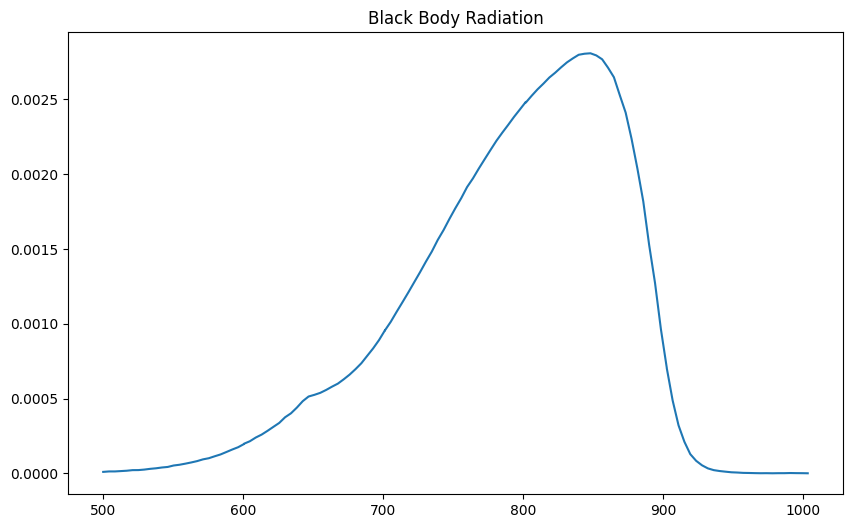

In [12]:
from os import path

# Black Body dataframe
BB_Exp_df = pd.read_csv(path.join(OUT_PATH['results_dir'], 'black_body.csv'),
                        dtype='float64', 
                        converters={'meta' : str})

# the wl will be in nanometers but the data is in angstroms
# so we must divide by 10 to get the correct units
BB_Exp_df['wl'] = BB_Exp_df['wl'] / 10

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Black Body Radiation')
ax.plot(BB_Exp_df['wl'], BB_Exp_df['mean'], label='Black Body Radiation')


Here we want to fit the theoretical BB spectrum on top of the experimental measurements. We suppose they are proportional to eachother and fit for the proportionality constant. Only on the far left the proportionality relation holds so we fit in that region, after that the responce function is different from one and can be used to model the experimental responce.

In [1]:
from scipy.optimize import curve_fit

# fitting for the proportionality coeff
fit = lambda x, a :  a * x
wl = BB_Exp_df['wl']
mean = BB_Exp_df['mean']
theo = utils.plank(wl, 1240)

fig, axs = plt.subplots(1,3, sharey='row', figsize=(9,3))
plt.tight_layout()
for ax in axs.flatten():
    ax.set(xlabel = r'wavelenght $[nm]$')

arr_start = [0, 36, 0]
arr_stop =  [36, 70, 60]
arr_zoom = [[.05e8, .3e8 ], 
            [.05e8, .7e8 ], 
            [.05e8, .7e8 ]]

for start, stop, zoom, ax in zip(arr_start, arr_stop, arr_zoom, axs.flatten()):
    # optimize the proportionality coeff
    try:
        popt, pcov = curve_fit(fit, mean[start:stop], theo[start:stop], p0=[1e11], bounds=(1e10, 1e12), method='trf')
    except RuntimeError as e:
        print(e)
    A = popt[0] 

    # plot
    ax.plot(wl * 1e9, mean * A)
    ax.plot(wl * 1e9, theo)
    ax.set(ylim=(0,.5e9))
    
    # color the fitted region
    ax.axvspan(wl[start] * 1e9, wl[stop] * 1e9, color='yellow', alpha=0.3, label='fitted data')

    # Define the area for the zoomed-in square (in data coordinates)
    x1, x2, y1, y2 = 600, 750, *zoom  # Adjust as needed

    # Add the inset zoomed-in plot
    ax_inset = inset_axes(ax, width="60%", height="40%", loc="upper left")  # Location and size of the inset
    ax_inset.plot(wl * 1e9, mean * A)
    ax_inset.plot(wl * 1e9, theo)
    ax_inset.set_xlim(x1, x2)
    ax_inset.set_ylim(y1, y2)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.axvspan(wl[start] * 1e9, wl[stop] * 1e9, color='yellow', alpha=0.3, label='fitted data')

    # Add a rectangle on the main plot to show the inset location
    ax.indicate_inset_zoom(ax_inset)

NameError: name 'BB_Exp_df' is not defined

Get the responce function of the system. The first part of the responce it's noisy so it's best to do a linear regression

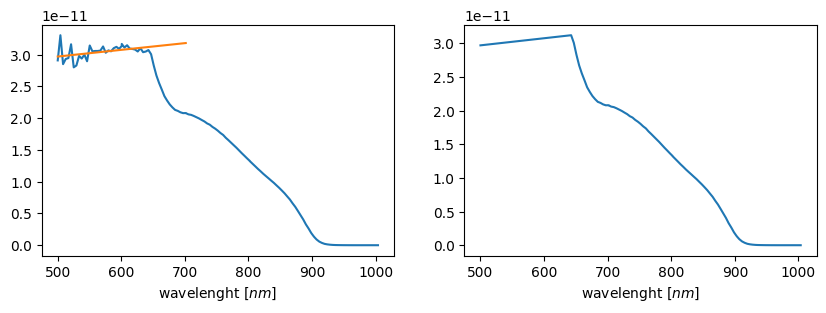

In [5]:
from scipy.stats import linregress

# responce function of the setup
responce = mean / theo

# linear fit of the responce function until
# the discontinuity point (knee) in the data
res = linregress(wl[:36], responce[:36])

# save the responce function
np.savetxt('Clean_Data\\responce.csv', np.array([wl, responce]).T, delimiter=',')

fig, axs = plt.subplots(1,2,figsize=(10,3))
axs = axs.flatten()
axs[0].plot(wl * 1e9, responce)
axs[0].plot(wl[:50] * 1e9, np.polyval(res[:2],wl[:50]))
axs[0].set(xlabel=r'wavelenght $[nm]$')

# update responce 
responce[:36] = np.polyval(res[:2],wl[:36])
axs[1].plot(wl * 1e9, responce)
_ = axs[1].set(xlabel=r'wavelenght $[nm]$')

## Sodium Lamp Spectrum

In [6]:
from importlib import reload
reload(utils)

Na_files = utils.getFiles('Raw_Data\\Na_Spectrum')
Na_files = utils.getFiles('Raw_Data\\Na_Spectrum')
Na_df = pd.DataFrame([utils.file_to_series(file) for file in Na_files], )
Na_df.head()

,type,date,id,interval,wl,mean,std,meta
0,Na,29102024,010,"[8175.2007, 8205.0]","[8175.2007, 8175.404, 8175.6045, 8175.805, 817...","[-7.35e-06, -6.33e-06, -5.16e-06, -6.1e-06, -5...","[1.8570494e-06, 7.233948e-07, 1.6485246e-06, 1...","{'type': 'Na', 'integration time': '1000ms', '..."
1,Na,29102024,004,"[5880.303, 5910.0]","[5880.303, 5880.6064, 5880.9097, 5881.213, 588...","[1.33e-06, 1e-06, 1e-06, 1e-06, 1.33e-06, 1e-0...","[5.7735025e-07, 0.0, 0.0, 0.0, 5.7735025e-07, ...","{'type': 'Na', 'integration time': '300ms', 'P..."
2,Na,17102024,001,"[5850.962, 5935.0]","[5850.962, 5851.6743, 5852.387, 5853.0996, 585...","[-3.67e-06, -2.67e-06, -3e-06, -3e-06, -3.33e-...","[1.1547004e-06, 2.5166114e-06, 0.0, 0.0, 2.886...","{'type': 'Na', 'integration time': '300ms', 'P..."
3,Na,17102024,002,"[5880.321, 5910.0]","[5880.321, 5880.4385, 5880.558, 5880.6777, 588...","[5e-06, 4.33e-06, 5e-06, 4.33e-06, 5e-06, 5e-0...","[0.0, 1.1547004e-06, 0.0, 1.1547004e-06, 0.0, ...","{'type': 'Na', 'integration time': '300ms', 'P..."
4,Na,17102024,003,"[5880.303, 5910.0]","[5880.303, 5880.6064, 5880.9097, 5881.213, 588...","[7e-08, 1.3e-07, 2.7e-07, 3e-08, 3e-08, 3.3e-0...","[2.5166116e-07, 5.7735026e-08, 5.7735033e-08, ...","{'type': 'Na', 'integration time': '300ms', 'P..."


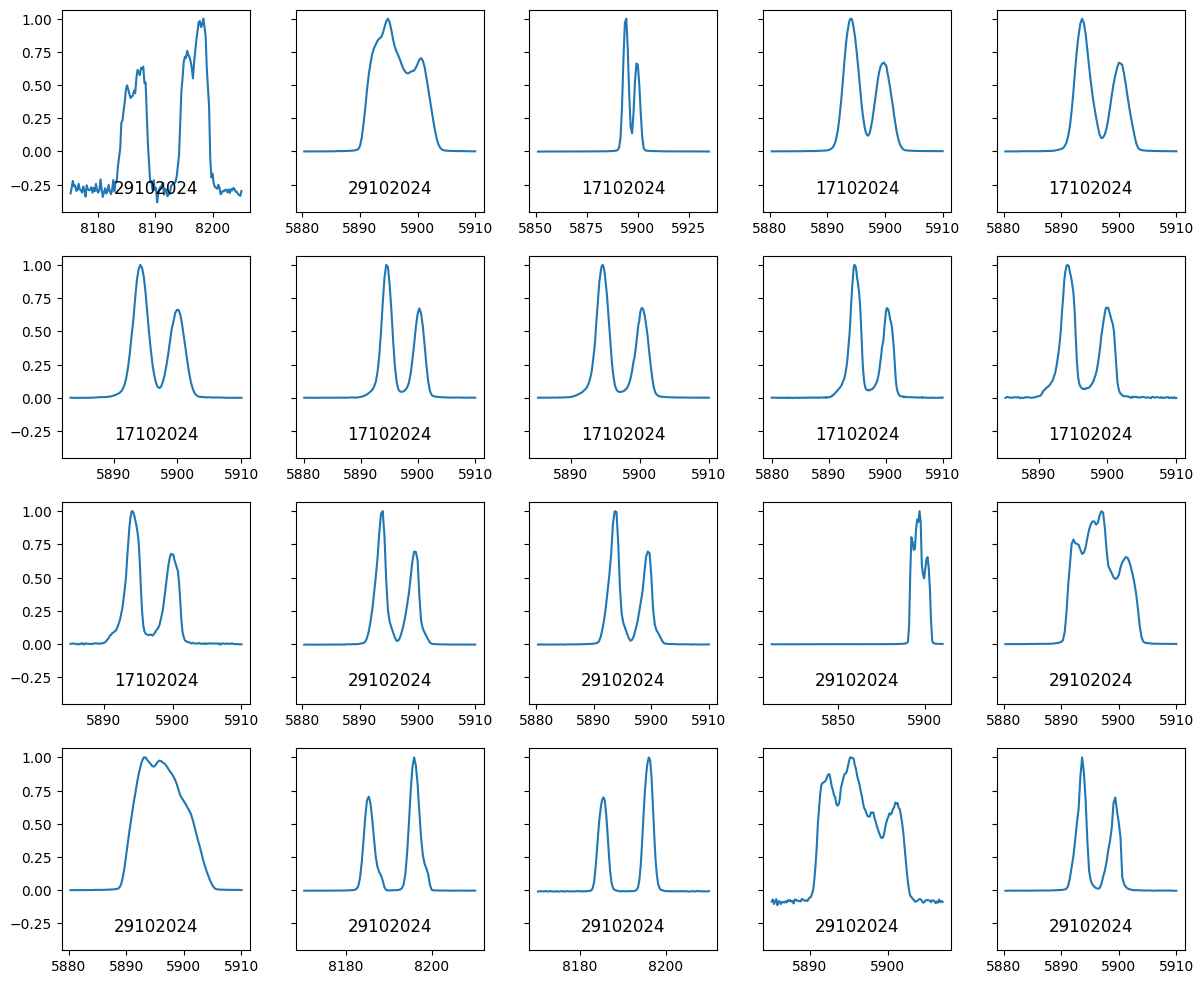

In [19]:
# plot all the data
fig, axs = plt.subplots(4, 5, figsize=(12, 10), sharey=True)
fig.subplots_adjust(wspace=0.10, right=0.95,
                    hspace=0.45, top=0.95)
fig.tight_layout()

groups = Na_df.groupby('meta')
for i, [name, group] in enumerate(groups):
    ax = axs.flatten()[i]
    
    # The data encapsulation is sooooo bad :*(
    mean = group.get('mean').values[0]
    wl = group.get('wl').values[0]

    # normalize the data
    mean = mean / mean.max()
    ax.plot(wl, mean)
    ax.set_title(f'{group.get("date").values[0]}', y = 0.05)

# Fitting the data at 800 nm
There should be a noticeable difference between the raw data and the correction of the responce function

Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).


mean noise : -6.7414285e-06
LinregressResult(slope=-1.759357254416204e-08, intercept=0.00013731916767800687, rvalue=-0.35052166665981827, pvalue=0.013541316531248689, stderr=6.8568295054881755e-09, intercept_stderr=5.6145508729020985e-05)
Bbox(x0=8182.0, y0=1e-06, x1=8189.0, y1=5.6e-05)
[[Variables]]
    amp_1:    8.8449e-05 (init = 0.00022)
    cen_1:    8186.51310 (init = 8185.5)
    sig_1:    2.04620996 (init = 0.9)
    gamma_1: -0.55198563 (init = 0.9)
    amp_2:    1.1700e-04 (init = 0.00035)
    cen_2:    8196.99531 (init = 8196)
    sig_2:    2.33188316 (init = 0.9)
    gamma_2: -1.01975633 (init = 0.9)
    y0:       1.2000e-06 (init = 1.2e-06)


Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8128 ticks ([448.0, ..., 8575.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 8128 ticks ([448.0, ...,

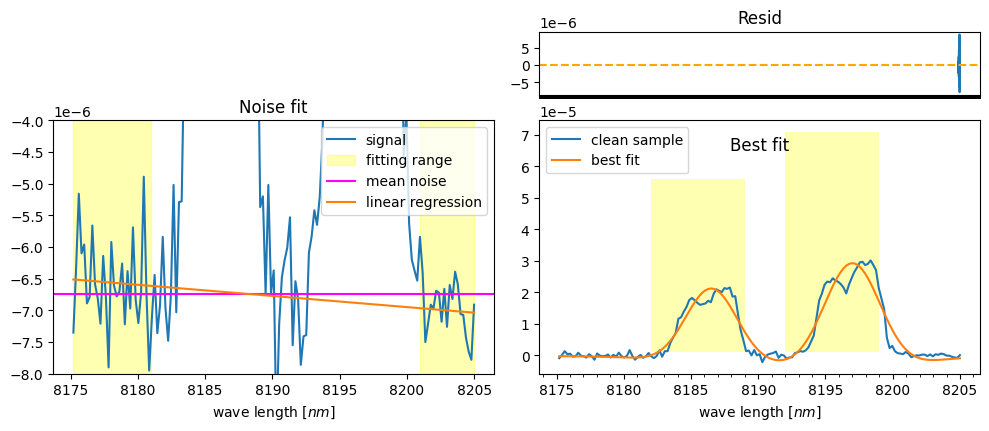

In [26]:
from lmfit import Minimizer, create_params, report_fit
from lmfit.lineshapes import gaussian, lorentzian, voigt
from scipy.stats import linregress
from pprint import pprint
from matplotlib.patches import Rectangle

# fitting at 800nm
sample = Na_df[Na_df['date'] == '29102024']

# take the first sample
wl = sample['wl'][0]
mean = sample['mean'][0]


def residual(pars, x, data):
    model = (voigt(x, pars['amp_1'], pars['cen_1'], pars['sig_1'], pars['gamma_1']) +
             voigt(x, pars['amp_2'], pars['cen_2'], pars['sig_2'], pars['gamma_2']))
    return model - data

pfit = create_params(amp_1 = 0.00022, cen_1 = 8185.5, sig_1 = 0.9, gamma_1 = 0.9,
                     amp_2 = 0.00035, cen_2 = 8196, sig_2 = 0.9, gamma_2 = 0.9,
                     y0 = 1.2e-6)
# pfit['y0'].set(vary=False)
# pfit['cen_1'].set(value = 8185.46, vary=False)
# pfit['cen_2'].set(value = 8196.06, vary=False)

# fit the noise
noise_edgs = {'below' : 8181,
              'above' : 8201}

noise_mask = (wl < noise_edgs['below']) | (wl > noise_edgs['above'])
res = linregress(wl[noise_mask], mean[noise_mask])
print('mean noise :', np.mean(mean[noise_mask]))
pprint(res)

# remove the noise and fit
clean_sample = mean - np.polyval(res[:2], wl)

# do not fit the peaks and the far tails
peak1 = Rectangle((8182,1e-6), 7, 5.5e-5, edgecolor='none', facecolor='yellow', alpha = 0.3)
peak2 = Rectangle((8192,1e-6), 7, 7e-5, edgecolor='none', facecolor='yellow', alpha = 0.3)
print(peak1.get_bbox())


mini = Minimizer(residual , pfit, fcn_args=(wl, clean_sample))
out = mini.leastsq()
best_fit = clean_sample + out.residual
report_fit(out.params)

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.10, right=0.95,
                    hspace=0.45, top=0.95)
axs = axs.flatten()

axs[0].set_title('Noise fit')
axs[0].set(ylim=(-8e-6, -4e-6))

# noise fit
axs[0].plot(wl, mean, label='signal')
axs[0].axvspan(wl.min(), noise_edgs['below'], color='yellow', alpha=0.3, label='fitting range')
axs[0].axhline(np.mean(mean[noise_mask]), c = 'magenta', label='mean noise')
axs[0].axvspan(noise_edgs['above'], wl.max(), color='yellow', alpha=0.3)
axs[0].plot(wl, np.polyval(res[:2], wl), label = 'linear regression')

# Best fit
axs[1].set_title('Best fit', y=.85)
axs[1].plot(wl, clean_sample, label='clean sample')
axs[1].plot(wl, best_fit, label='best fit')
axs[1].add_patch(peak1)
axs[1].add_patch(peak2)
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
ax_resid = axs[1].inset_axes([0, 1.1, 1, 0.25], sharex=ax)

# resid
ax_resid.set_title('Resid')
ax_resid.plot(wl, out.residual, label='resid')
ax_resid.axhline(0, c='orange', ls='--')
ax_resid.set_xticks([])

for ax in axs:
    ax.legend()
    ax.set(xlabel=r'wave length $[nm]$')
    
fig.tight_layout()

Now we study the effect of the responce function:

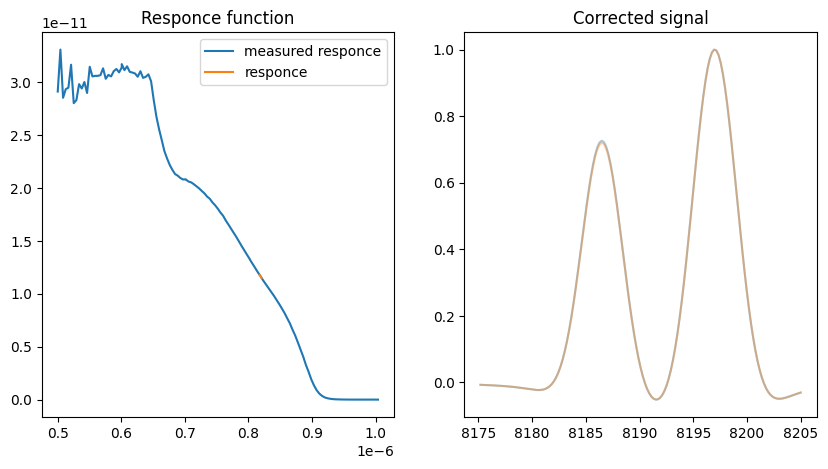

In [9]:
from scipy.interpolate import interp1d
fig, axs = plt.subplots(1, 2, figsize=(10,5))

responce = np.genfromtxt('Clean_Data\\responce.csv', delimiter=',').T
responce_wl = responce[0]
responce = responce[1]

# interpolate the responce function in the signal range
int_resp = interp1d(responce_wl, responce, kind='linear')

# responce function
axs[0].set_title('Responce function')
axs[0].plot(responce_wl, responce, label='measured responce')
axs[0].plot(wl * 1e-10, int_resp(wl * 1e-10), label='responce')

# corrected signal
axs[1].set_title('Corrected signal')
axs[1].plot(wl, best_fit / max(best_fit), alpha = .4, label='signal')
corr = best_fit / int_resp(wl * 1e-10)
axs[1].plot(wl, corr / max(corr), alpha = .4, label='corrected signal')

axs[0].legend()

## Laser
Iniziamo l'analisi dallo spettro del laser poiché è il più semplice, consistendo di un solo picco

In [10]:
from scipy.stats import cauchy

laser_spectrum = utils.getFiles('Cleaned_Data\\Laser_Spectrum')
laser_spectrum = utils.dfFormFiles(laser_spectrum, index_col=0)

fig, ax = plt.subplots()
laser_spectrum.groupby('meta').plot('wl', 'mean', ax=ax)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'c:\\Users\\alber\\Documents\\Uni\\Magistrale\\Lab_Materia_Condensata\\Cleaned_Data\\Laser_Spectrum'

[2.62935519e-02 6.33368338e+03 5.36532238e-01]


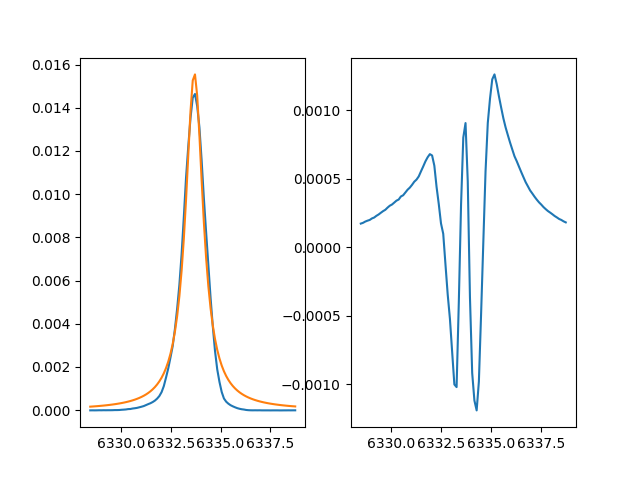

In [ ]:
# select the best measure and do a fit
sample = laser_spectrum[laser_spectrum['meta'] == 'laser_300ms_400V_1tac_out1tac_307Hz_002_29102024']
fit = lambda x, A, mu, gamma : A * cauchy.pdf(x, mu, gamma)

p0 = (3, 6330, 0.5)
popt, pcov = curve_fit(fit, sample['wl'], sample['mean'], p0=p0)
print(popt)

wl = sample['wl']
mean = sample['mean']

fig, axs = plt.subplots(1,2)
axs[0].plot(wl, mean)
axs[0].plot(wl, popt[0] * cauchy.pdf(wl, popt[1], popt[2]))
axs[1].plot(wl, popt[0] * cauchy.pdf(wl, popt[1], popt[2]) - mean)

Sembrerebbe che si siano due picchi e non uno!

In [ ]:
# select the best measure and do a fit
sample = laser_spectrum[laser_spectrum['meta'] == 'laser_300ms_400V_1tac_out1tac_307Hz_002_29102024']
fit = lambda x, A, mu, gamma : A * cauchy.pdf(x, mu, gamma)
def fit2 (x, A, muA, gammaA, B, muB, gammaB):
    print(x, A, muA, gammaA, B, muB, gammaB) 
    A * cauchy.pdf(x, muA, gammaA) + B * cauchy.pdf(x, muB, gammaB)

p0 = (1.5, 6333, 0.5, 1.5, 6330, 0.5)
popt, pcov = curve_fit(fit2, sample['wl'], sample['mean'], p0=p0, method='trf')
print(popt)

wl = sample['wl']
mean = sample['mean']

fig, axs = plt.subplots(1,2)
axs[0].plot(wl, mean)
axs[0].plot(wl, popt[0] * cauchy.pdf(wl, popt[1], popt[2]))
axs[1].plot(wl, popt[0] * cauchy.pdf(wl, popt[1], popt[2]) - mean)

35     6328.4630
36     6328.5747
37     6328.6865
38     6328.7990
39     6328.9106
         ...    
123    6338.2970
124    6338.4087
125    6338.5186
126    6338.6310
127    6338.7427
Name: wl, Length: 93, dtype: float64 1.5 6333.0 0.5 1.5 6330.0 0.5


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'